In [1]:
%run 'Functions.ipynb'

In [2]:
def terms_by_day(terms, start='1900-01-01', end='2020-01-01'):
    all_terms = Search(index='hep-analysis')[0:0] \
        .filter('range', earliest_date={'gte': start, 'lt': end})
    all_terms.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval='day',
        format='date_optional_time'
    )

    given_terms = all_terms.query('match_phrase', **{'abstracts.value': terms})
    x, y = unzip(given_terms.execute().aggregations.group_by_date.buckets)
 
    if not len(y):
        return [], []
    
    total_x, total_y = unzip(all_terms.execute().aggregations.group_by_date.buckets)
    
    start = np.where(total_x == min(x))[0][0]
    end = np.where(total_x == max(x))[0][0]
    total_y = total_y[start:end+1]
        
    with np.errstate(divide='ignore', invalid='ignore'):
        normed_y = np.divide(y, total_y)
        normed_y[~ np.isfinite(normed_y)] = 0
        return x, normed_y

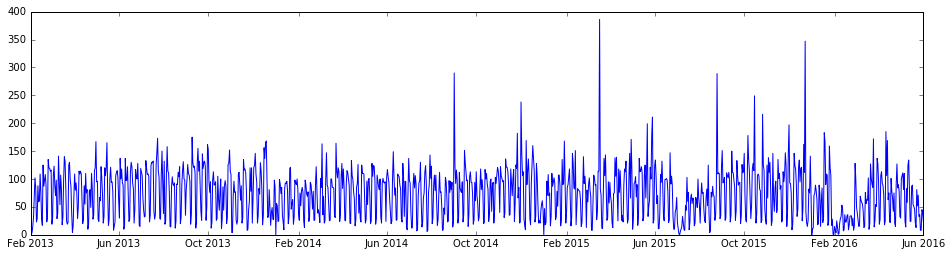

In [3]:
def all(start='1900-01-01', end='2020-01-01'):
    q = Search(index='hep-analysis')[0:0] \
    .filter('range', earliest_date={'gte': start, 'lt': end})
    q.aggs.bucket(
        'group_by_date', 
        'date_histogram', 
        field='earliest_date', 
        interval='day',
        format='date_optional_time'
    )
    return unzip(q.execute().aggregations.group_by_date.buckets)
x, y = all()
plt.plot(x, y)

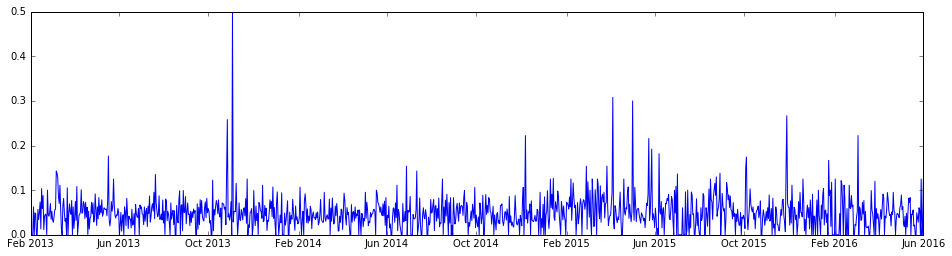

In [35]:
x, y = terms_by_day('gamma gamma')
plt.plot(x, y)

In [10]:
def repeat_sides(num, arr):
    arr = np.array(arr)
    left = np.ones(num) * arr[0]
    right = np.ones(num) * arr[-1]
    return np.append(left, np.append(arr, right))

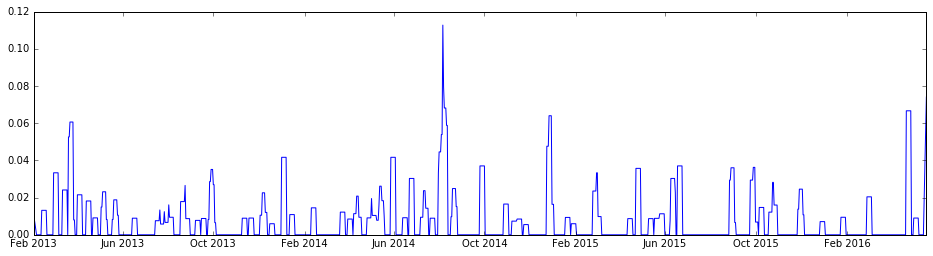

In [21]:
ay = sp.signal.convolve(repeat_sides(3, y), [1, 1, 1, 1, 1, 1, 1], mode='valid')
plt.plot(x, ay)

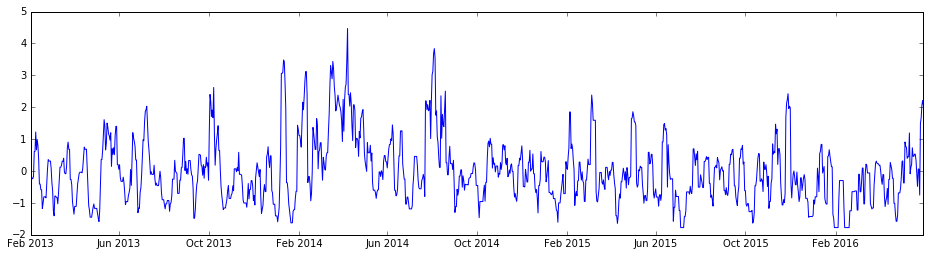

In [18]:
sy = sp.stats.zscore(ay)
plt.plot(x, sy)

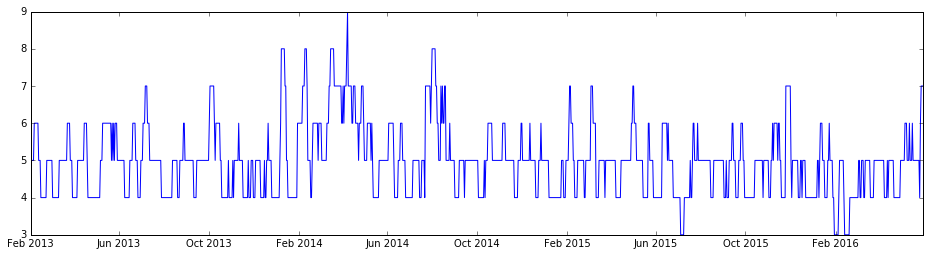

In [19]:
dy = np.digitize(sy, np.linspace(-5, 5, 10))
plt.plot(x, dy)

In [91]:
raw = fold_vectors(term_vectors(interval_ids('2013-03-01', days=600), 'abstracts.value'))

In [101]:
selected = {}
for k, v in sorted(raw.items()):
    if v['doc_freq'] >= 50:
        selected[k] = v

In [102]:
terms = list(selected.keys())[:100]

In [109]:
def align_origin(ax1, ax2):
    _, y1 = ax1.transData.transform((0, 0))
    _, y2 = ax2.transData.transform((0, 0))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1 - y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny + dy, maxy + dy)

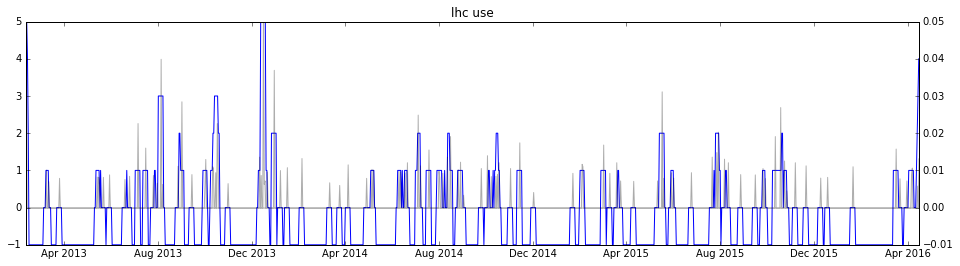

KeyboardInterrupt: 

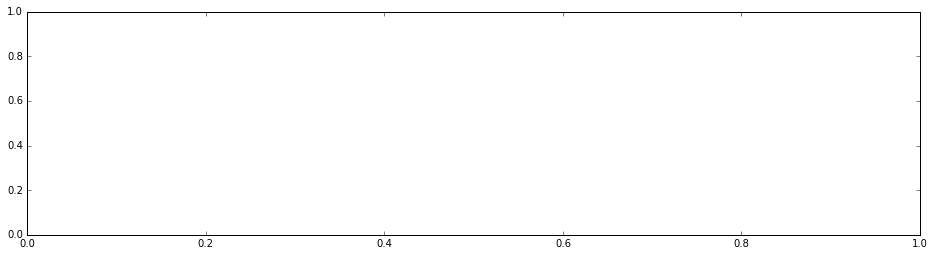

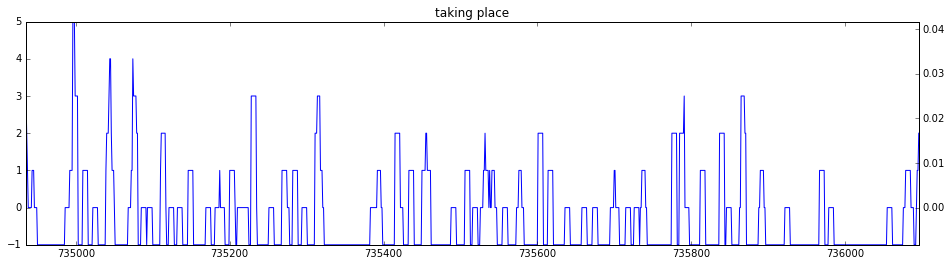

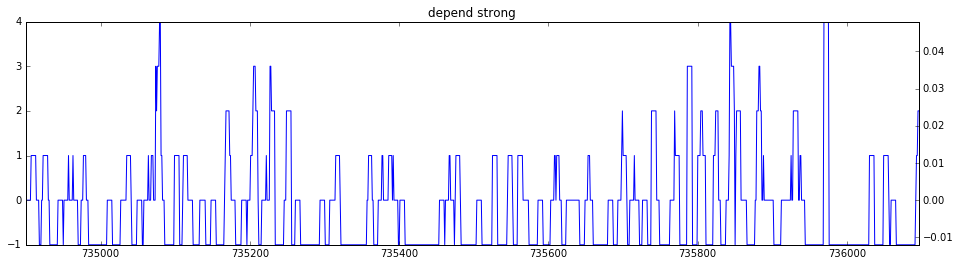

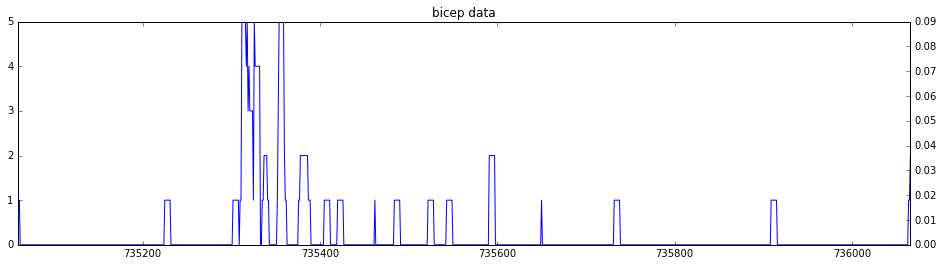

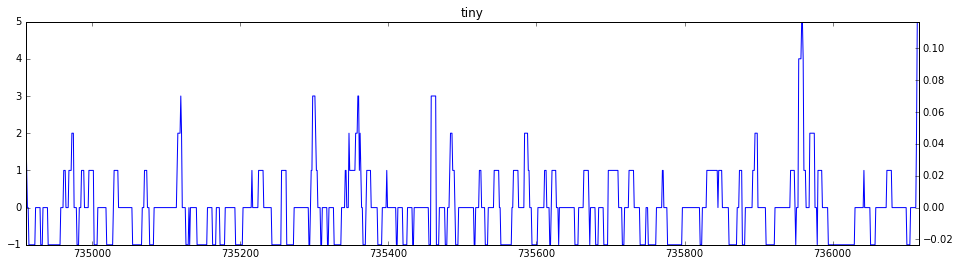

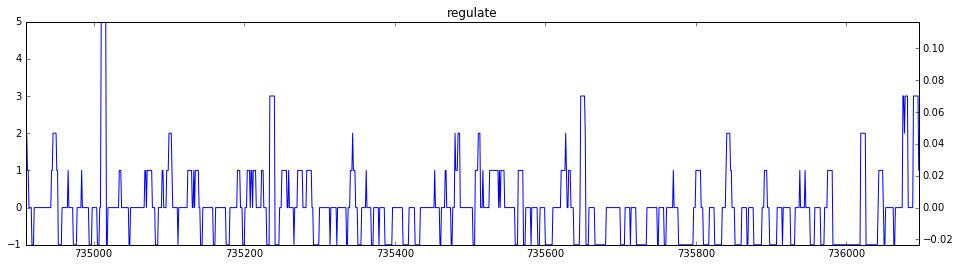

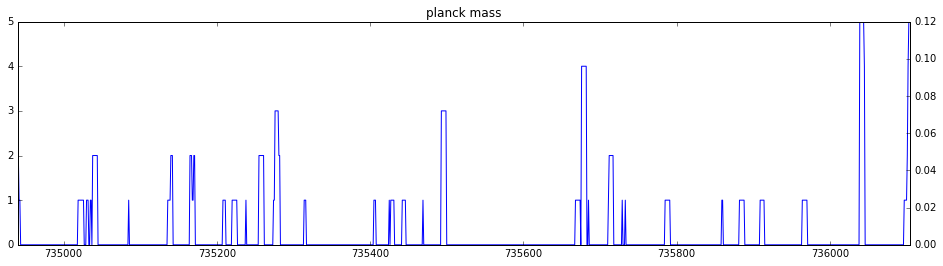

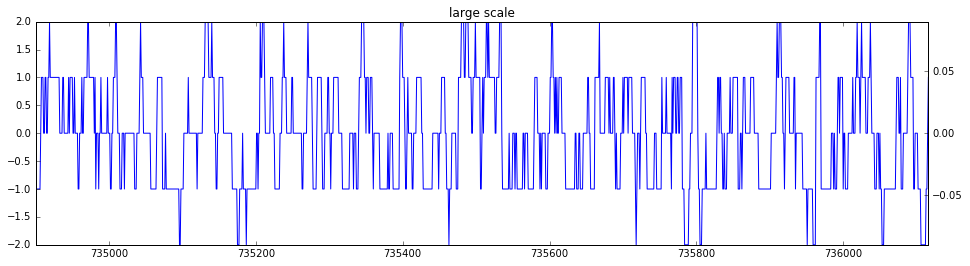

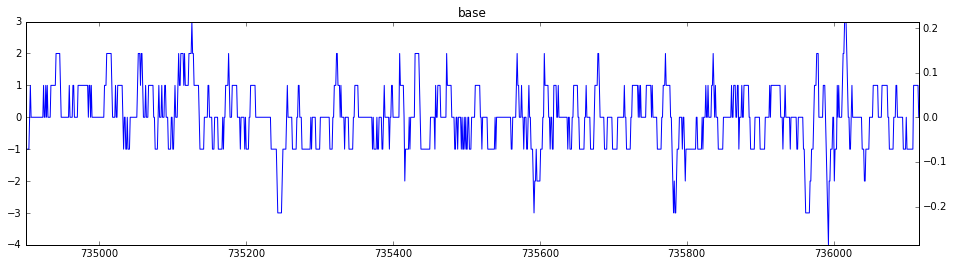

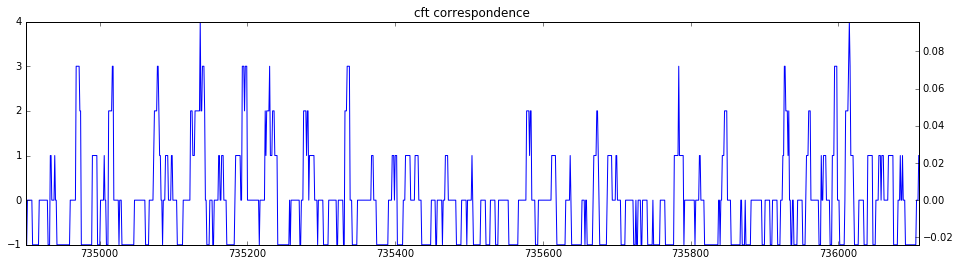

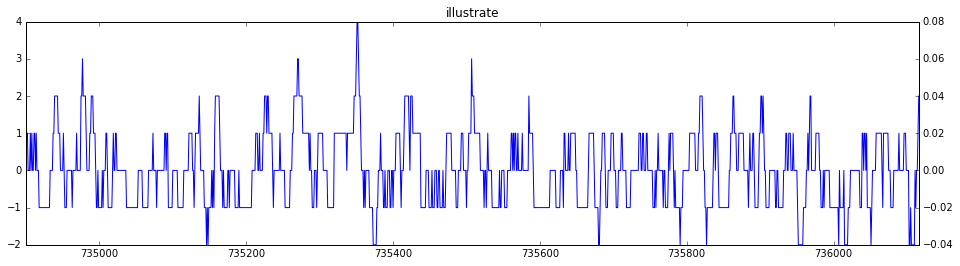

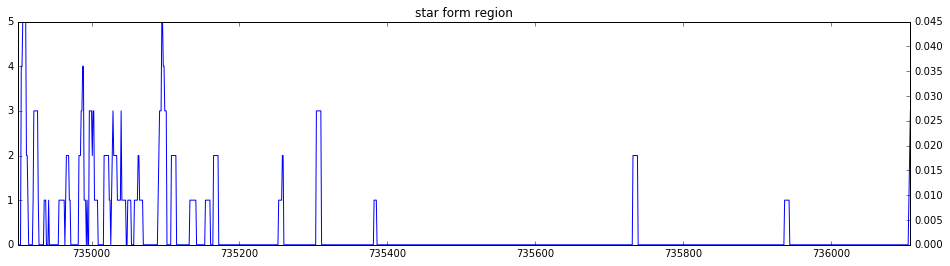

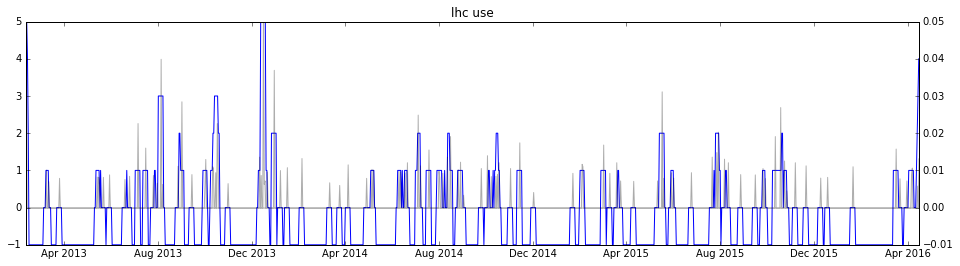

In [113]:
marked = []
unmarked = []

while True:

    term = np.random.choice(terms)
    x, y = terms_by_day(term)
    
    ay = sp.signal.convolve(repeat_sides(3, y), [1, 1, 1, 1, 1, 1, 1], mode='valid')
    sy = sp.stats.zscore(ay)
    dy = np.digitize(sy, np.linspace(-5, 5, 10))

    plt.gca().cla() 
    fig, ax1 = plt.subplots()
    plt.title(term)
    ax1.plot(x, dy - 5)
    ax2 = ax1.twinx()
    ax2.fill_between(x, 0, y, facecolor='lightgrey', alpha=0.3)
    align_origin(ax1, ax2)
    
    IPython.display.clear_output(wait=True)
    IPython.display.display(plt.gcf()) 

    command = input()
    if command == 'q':
        break
    elif command == 'a': # add mark
        marked.append(term)
    elif command == 'd': # delete mark
        unmarked.append(term)
        
display.clear_output()

In [114]:
marked

['bicep data', 'regulate', 'planck mass', 'illustrate', 'star form region']

In [115]:
unmarked

['taking place',
 'depend strong',
 'tiny',
 'large scale',
 'base',
 'cft correspondence']

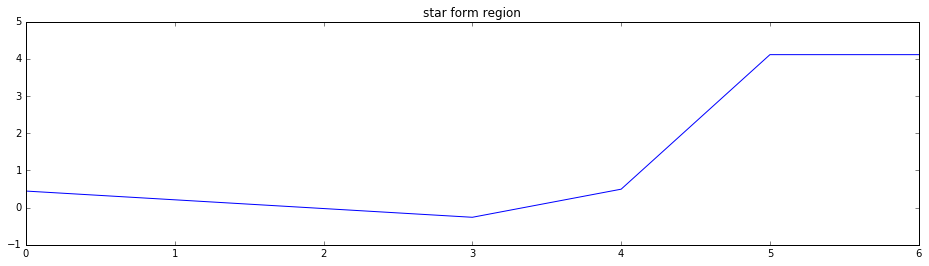

In [143]:
extracted = []

for term in marked:
    
    left = 0
    right = 10000
    running = True
        
    while True:
        x, y = terms_by_day(term)
        
        right = min(right, len(x) - 1)

        ay = sp.signal.convolve(repeat_sides(3, y), [1, 1, 1, 1, 1, 1, 1], mode='valid')
        sy = sp.stats.zscore(ay)

        plt.gca().cla() 
        plt.title(term)
        plt.plot(sy[left:right])

        IPython.display.clear_output(wait=True)
        IPython.display.display(plt.gcf()) 

        command = input()
        if command == 'q':
            running= False
            break
        elif command == 'r':
            left = 0
            right = 10000
        elif command == 'a': # crop left
            left += 100
        elif command == 'd': # crop right
            right -= 100
        elif command == 'w': # validate
            extracted.append({'term': term, 'from': x[left], 'to': x[right]})
            left = 0
            right = 10000
            break
            
    if not running:
        break
        
display.clear_output()

In [129]:
extracted

[{'from': datetime.datetime(2014, 1, 26, 0, 0),
  'term': 'bicep data',
  'to': datetime.datetime(2014, 8, 22, 0, 0)},
 {'from': datetime.datetime(2013, 2, 11, 0, 0),
  'term': 'regulate',
  'to': datetime.datetime(2013, 8, 17, 0, 0)}]

In [120]:
[1, 2, 4][-10000:]

[1, 2, 4]

In [134]:
right

1166

In [135]:
x

array([datetime.datetime(2013, 3, 13, 0, 0),
       datetime.datetime(2013, 3, 14, 0, 0),
       datetime.datetime(2013, 3, 15, 0, 0), ...,
       datetime.datetime(2016, 5, 19, 0, 0),
       datetime.datetime(2016, 5, 20, 0, 0),
       datetime.datetime(2016, 5, 21, 0, 0)], dtype=object)

In [140]:
y[right-1]

0.045454545454545456

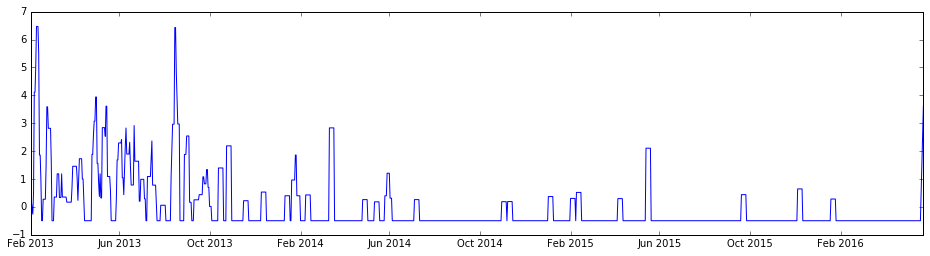

In [146]:
plt.plot(x, sy)

In [147]:
np.argmax(sy)

8